# Market Basket Clustering
This project uses market basket analysis to find:

Frequent items bought together (using Apriori Algorithm).

Customer segments (using K-Means and Hierarchical Clustering).

Dataset: Groceries dataset from Kaggle (38765,3)

In [ ]:
!pip install mlxtend plotly --quiet

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px

In [ ]:
from google.colab import files
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram
sns.set(style="whitegrid")

In [ ]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
print("\nDataset shape:", df.shape)
print(df.head())


Saving Groceries_dataset.csv to Groceries_dataset (2).csv

Dataset shape: (38765, 3)
   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk


One-hot encoding

In [ ]:
df.columns = [c.strip() for c in df.columns]
df['itemDescription'] = df['itemDescription'].astype(str).str.strip().str.lower()
df['Member_number'] = df['Member_number'].astype(str)

Converted dataset into a basket format:Rows = Customers, Columns = Items

Values = 0/1

Result: Basket shape = 3898 customers × 167 items

In [ ]:
basket = df.groupby(['Member_number', 'itemDescription']).size().unstack(fill_value=0)
basket = (basket > 0).astype(int)
print("\nBasket shape (customers x items):", basket.shape)

# Also create item frequency series for visualizations
item_freq = df['itemDescription'].value_counts().rename_axis('item').reset_index(name='count')



Basket shape (customers x items): (3898, 167)


# Apriori Algorithm
Finds items that are frequently bought together.

Uses three measures:

Support - Frequency of item(s).

Confidence - Probability of buying item B if item A is bought.

Lift - Strength of association (values > 1 show strong relation).

In [ ]:
min_support = 0.01
freq_itemsets = apriori(basket, min_support=min_support, use_colnames=True)
rules = association_rules(freq_itemsets, metric="lift", min_threshold=1.0)

# Sort and show top rules by lift
rules_sorted = rules.sort_values(by=['lift','confidence'], ascending=[False, False])
print("\nApriori: Frequent itemsets sample (top 10 by support):")
print(freq_itemsets.sort_values(by='support', ascending=False).head(10))
print("\nApriori: Top 8 rules by lift:")
display(rules_sorted[['antecedents','consequents','support','confidence','lift']].head(8))


Apriori: Frequent itemsets sample (top 10 by support):
       support                        itemsets
113   0.458184                    (whole milk)
68    0.376603              (other vegetables)
83    0.349666                    (rolls/buns)
93    0.313494                          (soda)
114   0.282966                        (yogurt)
105   0.233710                (tropical fruit)
84    0.230631               (root vegetables)
5     0.213699                 (bottled water)
88    0.206003                       (sausage)
1038  0.191380  (other vegetables, whole milk)

Apriori: Top 8 rules by lift:


,antecedents,consequents,support,confidence,lift
15181,"(other vegetables, sausage, whole milk)","(yogurt, rolls/buns)",0.013597,0.270408,2.428689
15188,"(yogurt, rolls/buns)","(other vegetables, sausage, whole milk)",0.013597,0.122120,2.428689
15177,"(other vegetables, rolls/buns, yogurt)","(sausage, whole milk)",0.013597,0.259804,2.428575
15192,"(sausage, whole milk)","(other vegetables, rolls/buns, yogurt)",0.013597,0.127098,2.428575
12782,"(yogurt, curd)","(sausage, whole milk)",0.010005,0.248408,2.322046
12787,"(sausage, whole milk)","(yogurt, curd)",0.010005,0.093525,2.322046
15178,"(rolls/buns, sausage, whole milk)","(other vegetables, yogurt)",0.013597,0.278947,2.318415
15191,"(other vegetables, yogurt)","(rolls/buns, sausage, whole milk)",0.013597,0.113006,2.318415


Most frequent single item: Whole milk (support ~0.46).

Frequent combos: “Whole milk + Vegetables” had high support.

/tmp/ipython-input-3622146375.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




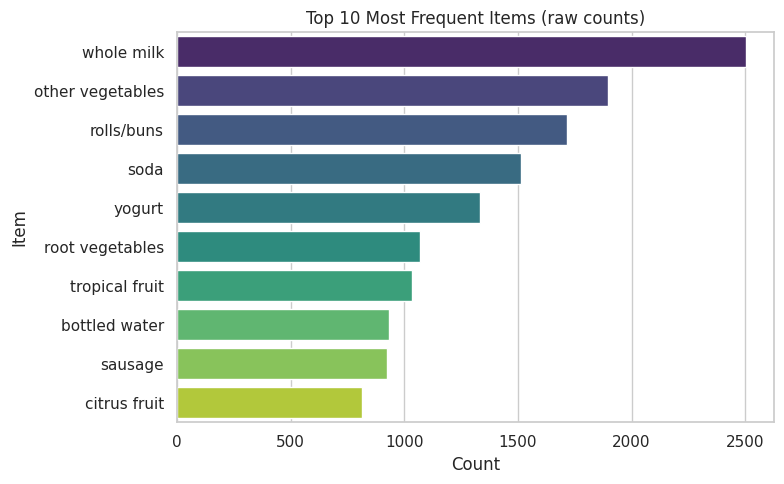

In [ ]:
top_items = item_freq.head(10)
plt.figure(figsize=(8,5))
sns.barplot(x='count', y='item', data=top_items, palette='viridis')
plt.title("Top 10 Most Frequent Items (raw counts)")
plt.xlabel("Count")
plt.ylabel("Item")
plt.tight_layout()
plt.show()

/tmp/ipython-input-4108546795.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




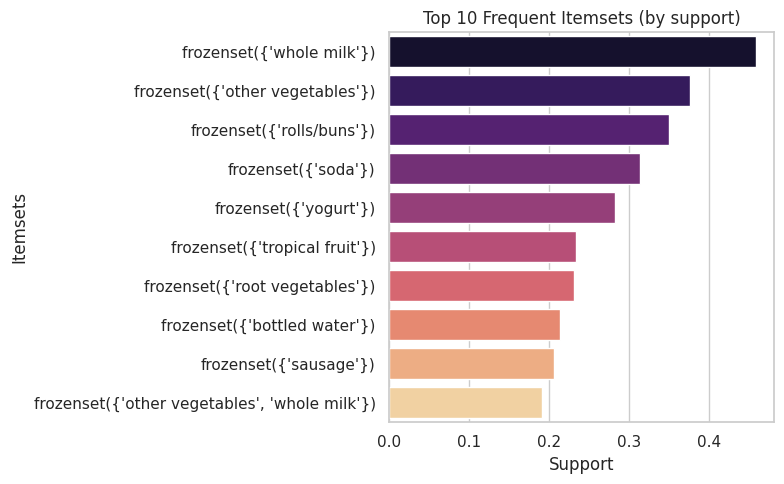

In [ ]:
top_itemsets = freq_itemsets.sort_values('support', ascending=False).head(10)
plt.figure(figsize=(8,5))
sns.barplot(x='support', y=top_itemsets['itemsets'].astype(str), data=top_itemsets, palette='magma')
plt.title("Top 10 Frequent Itemsets (by support)")
plt.xlabel("Support")
plt.ylabel("Itemsets")
plt.tight_layout()
plt.show()

Dimensionality Reduction (SVD and PCA)

Data is very large (167 items) hence we have used Truncated SVD to reduce features to 50 dimensions.

In [ ]:
svd_n = 50
svd = TruncatedSVD(n_components=min(svd_n, min(basket.shape)-1), random_state=42)
X_svd = svd.fit_transform(basket)   # shape: (n_customers, n_components)
print("Reduced shape:", X_svd.shape)

# Scale for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_svd)

Reduced shape: (3898, 50)


# K-Means Clustering

Metrics Used:

Silhouette Score → How well clusters are separated.

DBI (Davies–Bouldin Index) → Lower is better.

Calinski–Harabasz Score → Higher is better.

In [ ]:
sil_scores = {}
dbi_scores = {}
ch_scores = {}
k_range = range(2,7)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    sil_scores[k] = sil
    dbi_scores[k] = dbi
    ch_scores[k] = ch
    print(f"k={k} -> Silhouette={sil:.4f}, DBI={dbi:.4f}, CH={ch:.1f}")

k=2 -> Silhouette=0.0289, DBI=6.6002, CH=83.9
k=3 -> Silhouette=0.0366, DBI=5.4248, CH=78.0
k=4 -> Silhouette=0.0725, DBI=4.5716, CH=73.6
k=5 -> Silhouette=0.0284, DBI=4.6328, CH=73.8
k=6 -> Silhouette=0.0676, DBI=4.0915, CH=68.3


In [ ]:
best_k = max(sil_scores, key=sil_scores.get)
print(f"\nBest k by silhouette: {best_k} (silhouette={sil_scores[best_k]:.4f})")
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
k_labels = kmeans.fit_predict(X_scaled)


Best k by silhouette: 4 (silhouette=0.0725)


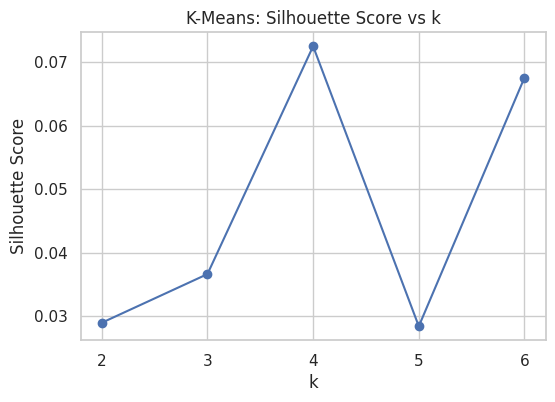

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("K-Means: Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.xticks(list(k_range))
plt.grid(True)
plt.show()

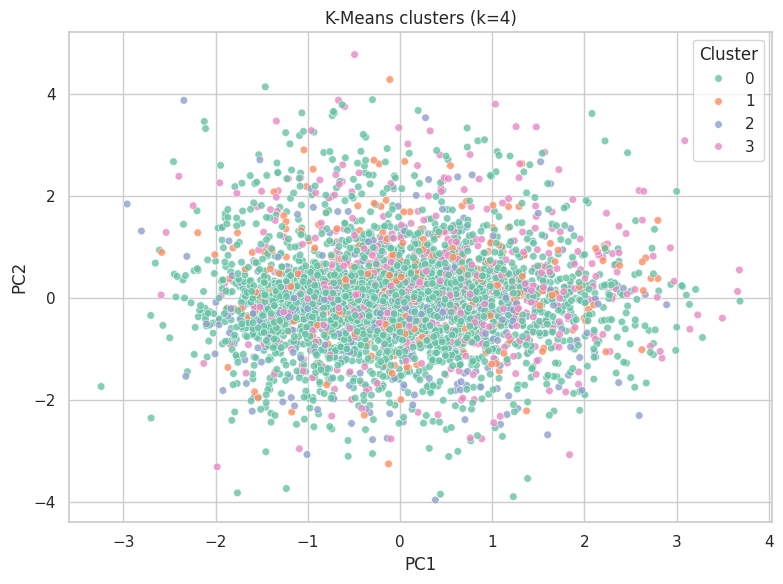

In [ ]:
pca2 = PCA(n_components=2, random_state=42)
X2 = pca2.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=k_labels, palette="Set2", s=30, alpha=0.8, legend='full')
plt.title(f"K-Means clusters (k={best_k})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

/tmp/ipython-input-3638222245.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




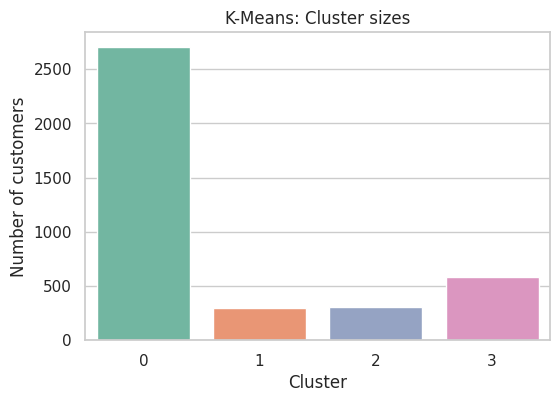

In [ ]:
k_counts = pd.Series(k_labels).value_counts().sort_index()
plt.figure(figsize=(6,4))
sns.barplot(x=k_counts.index, y=k_counts.values, palette="Set2")
plt.title("K-Means: Cluster sizes")
plt.xlabel("Cluster")
plt.ylabel("Number of customers")
plt.show()

# Hierarchical Clustering


Creating product dendrogram for top 50 products (by frequency)...


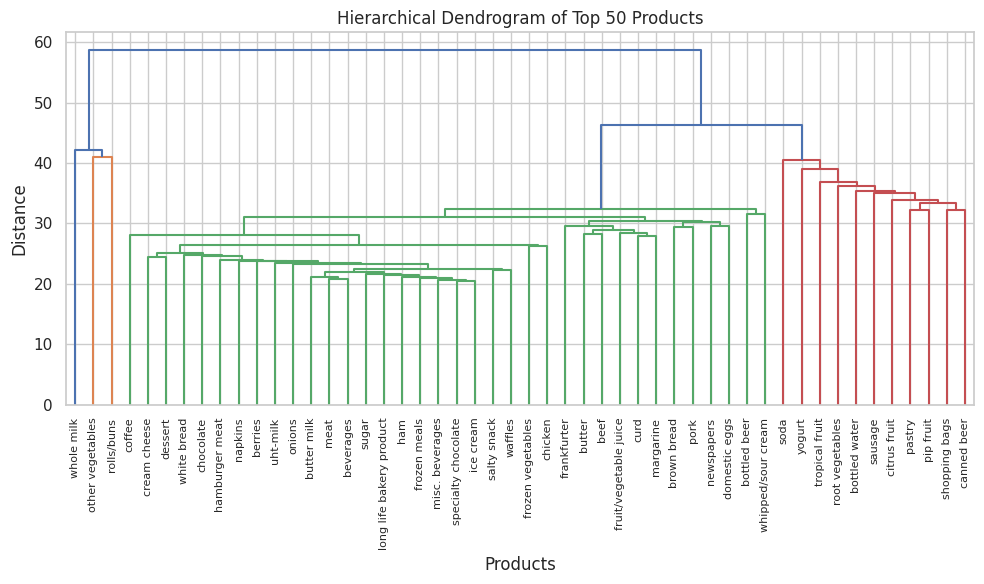

In [ ]:
topN = 50
top_products = item_freq.head(topN)['item'].tolist()
print(f"\nCreating product dendrogram for top {topN} products (by frequency)...")
# Build product x customer co-occurrence or product vectors (customers as columns)
prod_basket = basket[top_products].T  # rows = products, cols = customers
# linkage on product vectors
Z = linkage(prod_basket, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=prod_basket.index, leaf_rotation=90, leaf_font_size=8)
plt.title(f"Hierarchical Dendrogram of Top {topN} Products")
plt.xlabel("Products")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Agglomerative Clustering

In [ ]:
agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
h_labels = agg.fit_predict(X_scaled)

# Metrics for Hierarchical (customer-level)
h_sil = silhouette_score(X_scaled, h_labels)
h_dbi = davies_bouldin_score(X_scaled, h_labels)
h_ch = calinski_harabasz_score(X_scaled, h_labels)
print(f"Agglomerative : Silhouette={h_sil:.4f}, DBI={h_dbi:.4f}, CH={h_ch:.1f}")

Agglomerative : Silhouette=0.0575, DBI=4.2610, CH=44.0


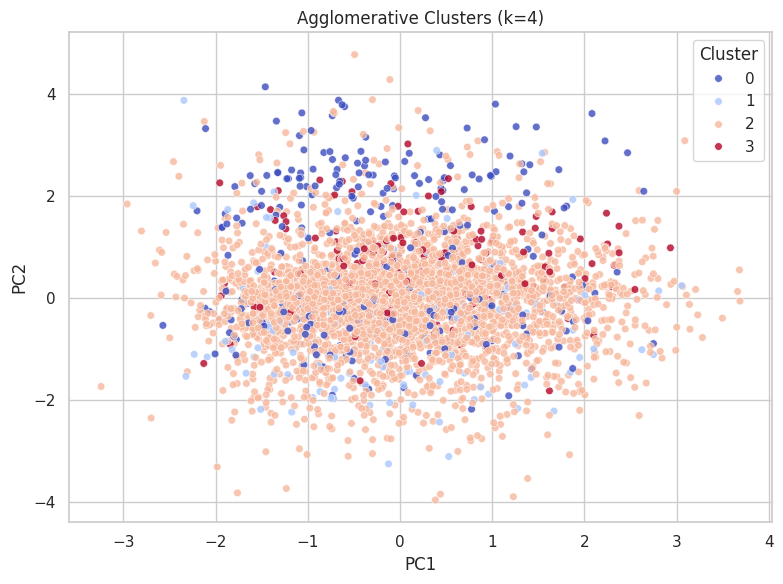

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=h_labels, palette="coolwarm", s=30, alpha=0.8, legend='full')
plt.title(f"Agglomerative Clusters (k={best_k})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

/tmp/ipython-input-3976136905.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




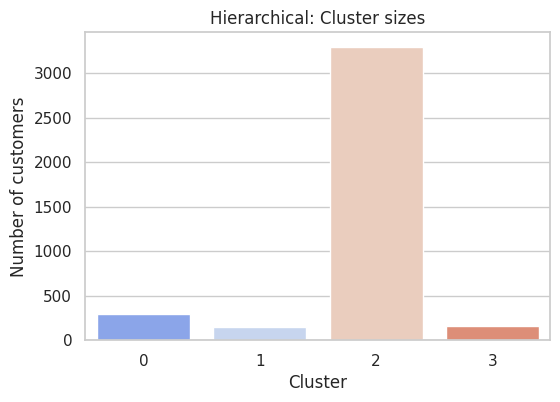

In [ ]:
h_counts = pd.Series(h_labels).value_counts().sort_index()
plt.figure(figsize=(6,4))
sns.barplot(x=h_counts.index, y=h_counts.values, palette="coolwarm")
plt.title("Hierarchical: Cluster sizes")
plt.xlabel("Cluster")
plt.ylabel("Number of customers")
plt.show()


# Evaluation Matrix

In [ ]:
ap_support_avg = freq_itemsets['support'].mean() if not freq_itemsets.empty else np.nan
ap_conf_avg = rules['confidence'].mean() if not rules.empty else np.nan
ap_lift_max = rules['lift'].max() if not rules.empty else np.nan
ap_num_rules = len(rules)

In [ ]:
k_sil = silhouette_score(X_scaled, k_labels)
k_dbi = davies_bouldin_score(X_scaled, k_labels)
k_ch = calinski_harabasz_score(X_scaled, k_labels)

h_sil = h_sil
h_dbi = h_dbi
h_ch = h_ch

In [ ]:
evaluation = pd.DataFrame({
    "Algorithm": ["Apriori Algorith", "K-Means Algorithm", "Hierarchical Clustering"],
    "Metric A": [f"Avg Support={ap_support_avg:.4f}", f"Silhouette={k_sil:.4f}", f"Silhouette={h_sil:.4f}"],
    "Metric B": [f"Avg Conf={ap_conf_avg:.4f}", f"DBI={k_dbi:.4f}", f"DBI={h_dbi:.4f}"],
    "Metric C": [f"Max Lift={ap_lift_max:.3f}; Rules={ap_num_rules}", f"CH={k_ch:.1f}", f"CH={h_ch:.1f}"]
})
print("\nEvaluation Matrix")
display(evaluation)


Evaluation Matrix


,Algorithm,Metric A,Metric B,Metric C
0,Apriori Algorith,Avg Support=0.0214,Avg Conf=0.1979,Max Lift=2.429; Rules=15260
1,K-Means Algorithm,Silhouette=0.0725,DBI=4.5716,CH=73.6
2,Hierarchical Clustering,Silhouette=0.0575,DBI=4.2610,CH=44.0


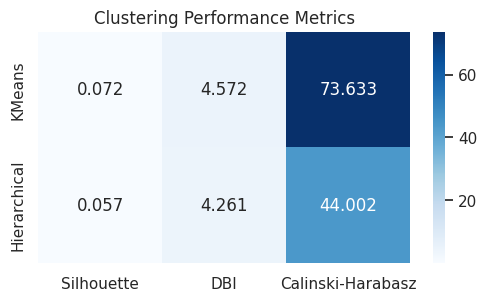

In [ ]:
eval_heat = pd.DataFrame({
    "Silhouette": [np.nan, k_sil, h_sil],
    "DBI": [np.nan, k_dbi, h_dbi],
    "Calinski-Harabasz": [np.nan, k_ch, h_ch]
}, index=["Apriori", "KMeans", "Hierarchical"])

plt.figure(figsize=(6,3))
sns.heatmap(eval_heat.iloc[1:], annot=True, fmt=".3f", cmap="Blues")
plt.title("Clustering Performance Metrics")
plt.show()